In [1]:
import pandas as pd
import numpy as np
import cooler
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
from matplotlib.patches import Patch
import scipy.io


from sklearn.decomposition import PCA
from scipy import stats
import networkx as nx
from sklearn.metrics import jaccard_score
from sklearn.metrics import roc_auc_score

import os
import sys
from importlib import reload

import filters
import pore_c_utils as pcu
import binning_utils as binning
import plotting as hicPlot
import imputation

In [2]:
assembly = pcu.loadAssembly("GRCm39_Assembly.txt")

chromDict = dict(zip(assembly['RefSeq accession'],assembly['Chromosome'].apply(lambda x : f"chr{x}")))

# the reverse for easy lookup
chromDict_r = {v: k for k, v in chromDict.items()}

chromOrder = list(chromDict.values())
chromOrder

['chr1',
 'chr2',
 'chr3',
 'chr4',
 'chr5',
 'chr6',
 'chr7',
 'chr8',
 'chr9',
 'chr10',
 'chr11',
 'chr12',
 'chr13',
 'chr14',
 'chr15',
 'chr16',
 'chr17',
 'chr18',
 'chr19',
 'chrX',
 'chrY']

In [3]:
scHICfilepath = f"/nfs/turbo/umms-indikar/shared/projects/poreC/nagano_2017_data/nagano_1MB_raw_BALANCED.scool"
cellList = list(cooler.fileops.list_coolers(scHICfilepath))
print(f"{len(cellList)=}")

len(cellList)=3882


NOTE: the raw data needs to be re-organized prior to extracting a single chromosome.

In [4]:
sampleSize = 1000
chromosome = ['chr2']
sample = np.random.choice(cellList, sampleSize, replace=False)

hic = {}

for i, s in enumerate(sample):
    filetag = "_".join(s.split("_")[0:2]).replace("/", "") + f"_{i}"
    rawMat, hicChromInfo, hicIndex = pcu.loadNagano2017SingleCell(scHICfilepath, s, chromOrder, balance=False)
    
    hicChromInfo = hicChromInfo[hicChromInfo['region'].str.contains('random') == False]
    
    # re-order  the matrix
    hicMat = rawMat[hicIndex, :][:, hicIndex]
    
    # extract the second chromosome
    chrHicInd = pcu.getIndices(hicChromInfo, hicIndex, chromosome, 'region')

    A = hicMat[chrHicInd, :][:, chrHicInd]
   
    # binarize 
    A = np.where(A > 0, 1, 0)
    hic[filetag] = A
#     print(f"{filetag=} {A.shape=}")
    
print('done.')
print(f"{len(hic.keys())=}")

done.
len(hic.keys())=1000


In [5]:
for k, v in hic.items():
    assert(v.shape == (182, 182))
#     if not v.shape == (182, 182):
#         print(k, v.shape)

<ipython-input-13-4807515a6553>:14: RuntimeWarning: divide by zero encountered in log
  pltEnsemble = np.where(ensembleTrue > 0, np.log(ensembleTrue), ensembleTrue)


Text(0.5, 1.0, 'Ensemble of Binary Single-Cells')

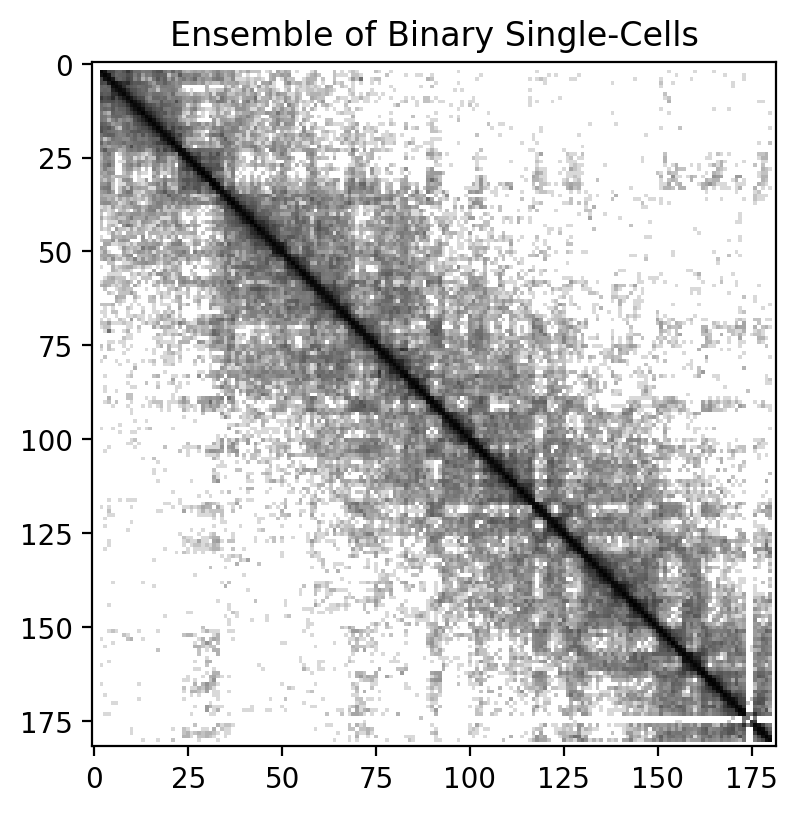

In [13]:
n = 100
sampleKeys = np.random.choice(list(hic.keys()), n)


ensembleTrue = np.zeros((182, 182))

for sampleKey in sampleKeys:
    ensembleTrue += hic[sampleKey]
    
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 15, 15
fig = plt.figure()

pltEnsemble = np.where(ensembleTrue > 0, np.log(ensembleTrue), ensembleTrue)

fig.add_subplot(131)
plt.imshow(pltEnsemble, cmap='binary')
plt.title(f'Ensemble of Binary Single-Cells')

In [7]:
# break

In [14]:
reload(imputation)

retain = 0.5

uniformMissing = imputation.randomUniformRemoval(hic, retain=retain)
print(f"{len(uniformMissing.keys())=}")

degreeLimit = imputation.degreeLimitRemoval(hic, retain=retain)
print(f"{len(degreeLimit.keys())=}")

crawlMissing = imputation.breadthFirstRemoval(hic, retain=retain)
print(f"{len(crawlMissing.keys())=}")

coldEnd = imputation.coldEndRemoval(hic, retain=retain)
print(f"{len(coldEnd.keys())=}")

print('done.')

len(uniformMissing.keys())=1000
len(degreeLimit.keys())=1000
len(crawlMissing.keys())=1000
len(coldEnd.keys())=1000
done.


In [15]:
# break

sampleKey='Diploid_23_978'


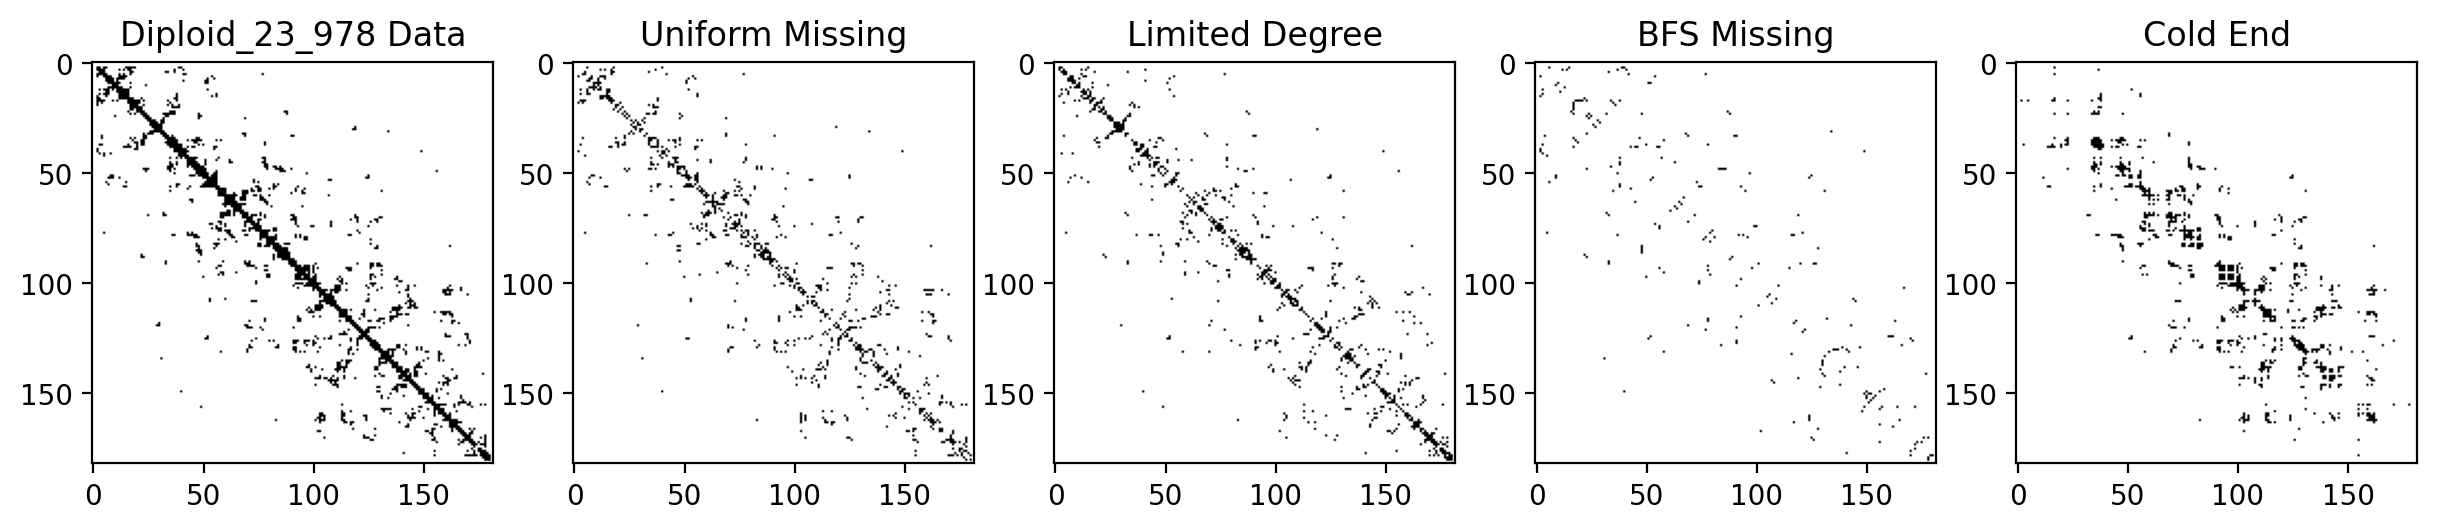

sampleKey='Diploid_30_401'


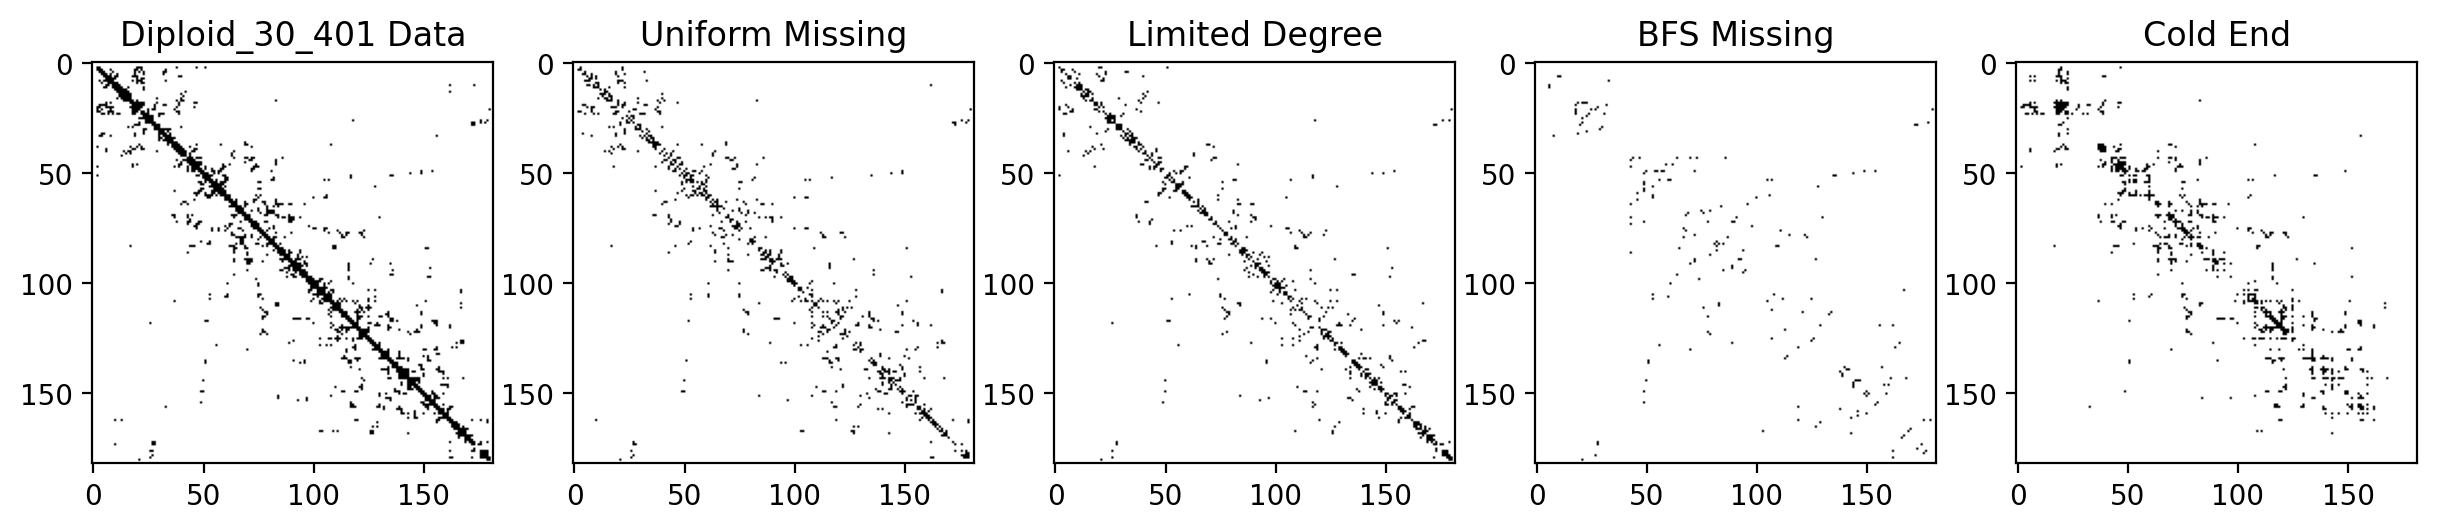

In [16]:
n = 2
sampleKeys = np.random.choice(list(coldEnd.keys()), n)

for sampleKey in sampleKeys:

    print(f"{sampleKey=}")

    plt.rcParams['figure.dpi'] = 200
    plt.rcParams['figure.figsize'] = 15, 15
    fig = plt.figure()

    fig.add_subplot(151)
    plt.imshow(hic[sampleKey], cmap='binary')
    plt.title(f'{sampleKey} Data')

    fig.add_subplot(152)
    plt.imshow(uniformMissing[sampleKey], cmap='binary')
    plt.title('Uniform Missing')

    fig.add_subplot(153)
    plt.imshow(degreeLimit[sampleKey], cmap='binary')
    plt.title('Limited Degree')

    fig.add_subplot(154)
    plt.imshow(crawlMissing[sampleKey], cmap='binary')
    plt.title('BFS Missing')

    fig.add_subplot(155)
    plt.imshow(coldEnd[sampleKey], cmap='binary')
    plt.title('Cold End')
    
    plt.show()

In [17]:
def evalJaccard(Atrue, Apred):
    return jaccard_score(Atrue.ravel(), Apred.ravel(), zero_division='ignore')

def evalJAUCROC(Atrue, Apred):
    try:
        r = roc_auc_score(Atrue.ravel(), Apred.ravel())
    except ValueError:
        r = 0.5
    return r

In [18]:
tau = 0.5

missingType = {
    'Random Uniform' : uniformMissing,
    'Degree Limited' : degreeLimit,
    'Crawl Limited' : crawlMissing,
    'Cold-end Limited' : coldEnd
}

predictionAlgo = {
    'Resource Allocation' : lambda x : imputation.imputeResource(x, tau),
    'CCPA' : lambda x : imputation.imputeCCPA(x, tau),
    'Adamic-Adar' : lambda x : imputation.imputeAdar(x, tau),
#     'Preferential Attachment' : lambda x : imputation.imputePrefAttach(x, tau),
}

evalMetrics = {
    'jaccard' : evalJaccard,
    'aucroc' : evalJAUCROC,
}


newRows = []

for key in hic.keys():
    
    for algoName, algoFunc in predictionAlgo.items():
        print(f"{algoName=}")
        for mTypeName, Adict in missingType.items():
            print(f"\t{mTypeName=}")
            for evalName, metricFunc in evalMetrics.items():
            
                Apred = algoFunc(Adict[key])
            
                met = metricFunc(hic[key], Apred)

                row = {
                    'cell' : key,
                    'predictionAlgorithm' : algoName,
                    'missingType' : mTypeName,
                    'evalMetric' : evalName,
                    'evalValue' : met,
                    'predMatrix' : Apred,
                    'trainMatrix' : Adict[key],
                    'trueMatrix' : hic[key],
                }
                newRows.append(row)
                
df = pd.DataFrame(newRows)
print(f"{df.shape=}")
df.head()

df.shape=(32000, 8)


,cell,predictionAlgorithm,missingType,evalMetric,evalValue,predMatrix,trainMatrix,trueMatrix
0,Diploid_4_0,Resource Allocation,Random Uniform,jaccard,0.494145,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",[[[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0....,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,Diploid_4_0,Resource Allocation,Random Uniform,aucroc,0.759063,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",[[[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0....,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,Diploid_4_0,Resource Allocation,Degree Limited,jaccard,0.474535,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",[[[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0....,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,Diploid_4_0,Resource Allocation,Degree Limited,aucroc,0.740853,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",[[[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0....,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,Diploid_4_0,Resource Allocation,Crawl Limited,jaccard,0.184838,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",[[[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0....,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


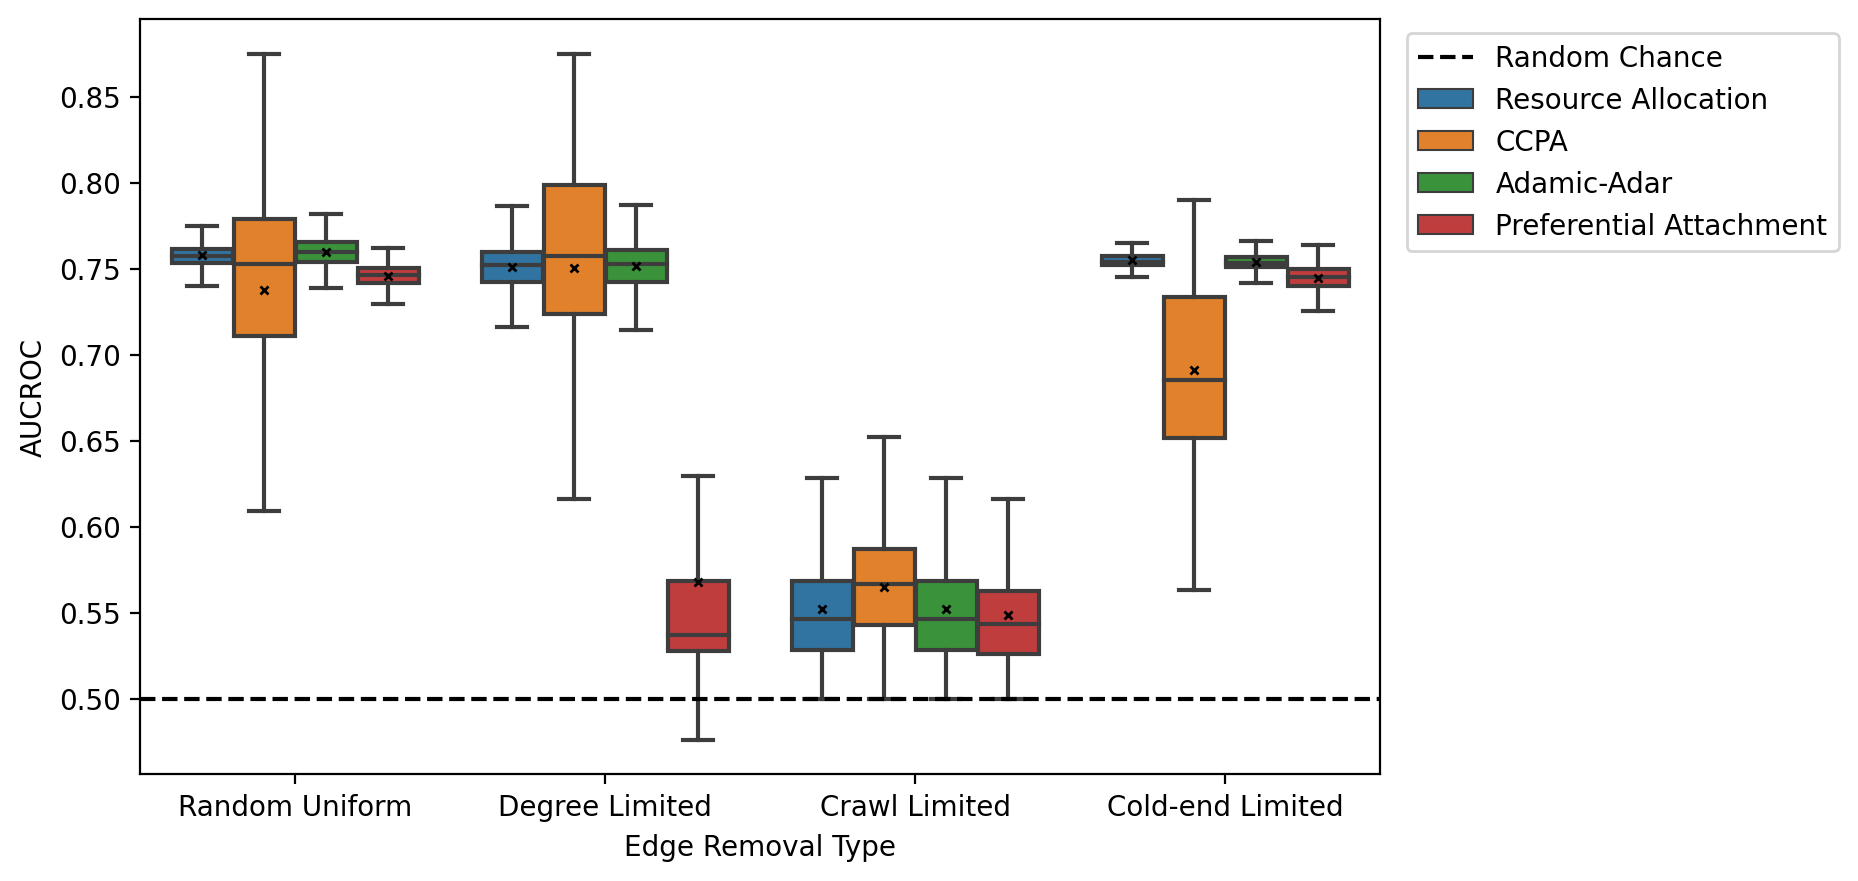

In [19]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 8, 5
fig = plt.figure()

    
tmp = df[df['evalMetric'] == 'aucroc']


sns.boxplot(data=tmp,
            x='missingType',
            hue='predictionAlgorithm',
            y='evalValue',
            showfliers=False,
            showmeans=True,
            meanprops={"marker":"x",
                       "markerfacecolor":"r", 
                       "markeredgecolor":"k",
                       "markersize":3})


plt.axhline(y=0.5, ls='--', c='k', label='Random Chance')

plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.ylabel('AUCROC')
plt.xlabel('Edge Removal Type')


plt.show()

In [20]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 8, 5
fig = plt.figure()


grped = df.groupby(['missingType', 'predictionAlgorithm', 'evalMetric']).agg(
    mean=('evalValue', 'mean'),
    std=('evalValue', 'std'),
).reset_index()

auc = grped[grped['evalMetric'] == 'aucroc']
print(auc.round(3).to_latex(index=False))




\begin{tabular}{lllrr}
\toprule
     missingType &     predictionAlgorithm & evalMetric &  mean &   std \\
\midrule
Cold-end Limited &             Adamic-Adar &     aucroc & 0.754 & 0.029 \\
Cold-end Limited &                    CCPA &     aucroc & 0.691 & 0.055 \\
Cold-end Limited & Preferential Attachment &     aucroc & 0.745 & 0.030 \\
Cold-end Limited &     Resource Allocation &     aucroc & 0.755 & 0.029 \\
   Crawl Limited &             Adamic-Adar &     aucroc & 0.552 & 0.049 \\
   Crawl Limited &                    CCPA &     aucroc & 0.565 & 0.050 \\
   Crawl Limited & Preferential Attachment &     aucroc & 0.549 & 0.048 \\
   Crawl Limited &     Resource Allocation &     aucroc & 0.552 & 0.049 \\
  Degree Limited &             Adamic-Adar &     aucroc & 0.751 & 0.032 \\
  Degree Limited &                    CCPA &     aucroc & 0.751 & 0.071 \\
  Degree Limited & Preferential Attachment &     aucroc & 0.568 & 0.074 \\
  Degree Limited &     Resource Allocation &     aucroc & 0

<Figure size 1600x1000 with 0 Axes>

In [21]:
auc = grped[grped['evalMetric'] == 'jaccard']
print(auc.round(3).to_latex(index=False))

\begin{tabular}{lllrr}
\toprule
     missingType &     predictionAlgorithm & evalMetric &  mean &   std \\
\midrule
Cold-end Limited &             Adamic-Adar &    jaccard & 0.491 & 0.061 \\
Cold-end Limited &                    CCPA &    jaccard & 0.184 & 0.136 \\
Cold-end Limited & Preferential Attachment &    jaccard & 0.352 & 0.129 \\
Cold-end Limited &     Resource Allocation &    jaccard & 0.500 & 0.060 \\
   Crawl Limited &             Adamic-Adar &    jaccard & 0.105 & 0.116 \\
   Crawl Limited &                    CCPA &    jaccard & 0.118 & 0.112 \\
   Crawl Limited & Preferential Attachment &    jaccard & 0.098 & 0.114 \\
   Crawl Limited &     Resource Allocation &    jaccard & 0.105 & 0.116 \\
  Degree Limited &             Adamic-Adar &    jaccard & 0.482 & 0.070 \\
  Degree Limited &                    CCPA &    jaccard & 0.258 & 0.143 \\
  Degree Limited & Preferential Attachment &    jaccard & 0.081 & 0.111 \\
  Degree Limited &     Resource Allocation &    jaccard & 0

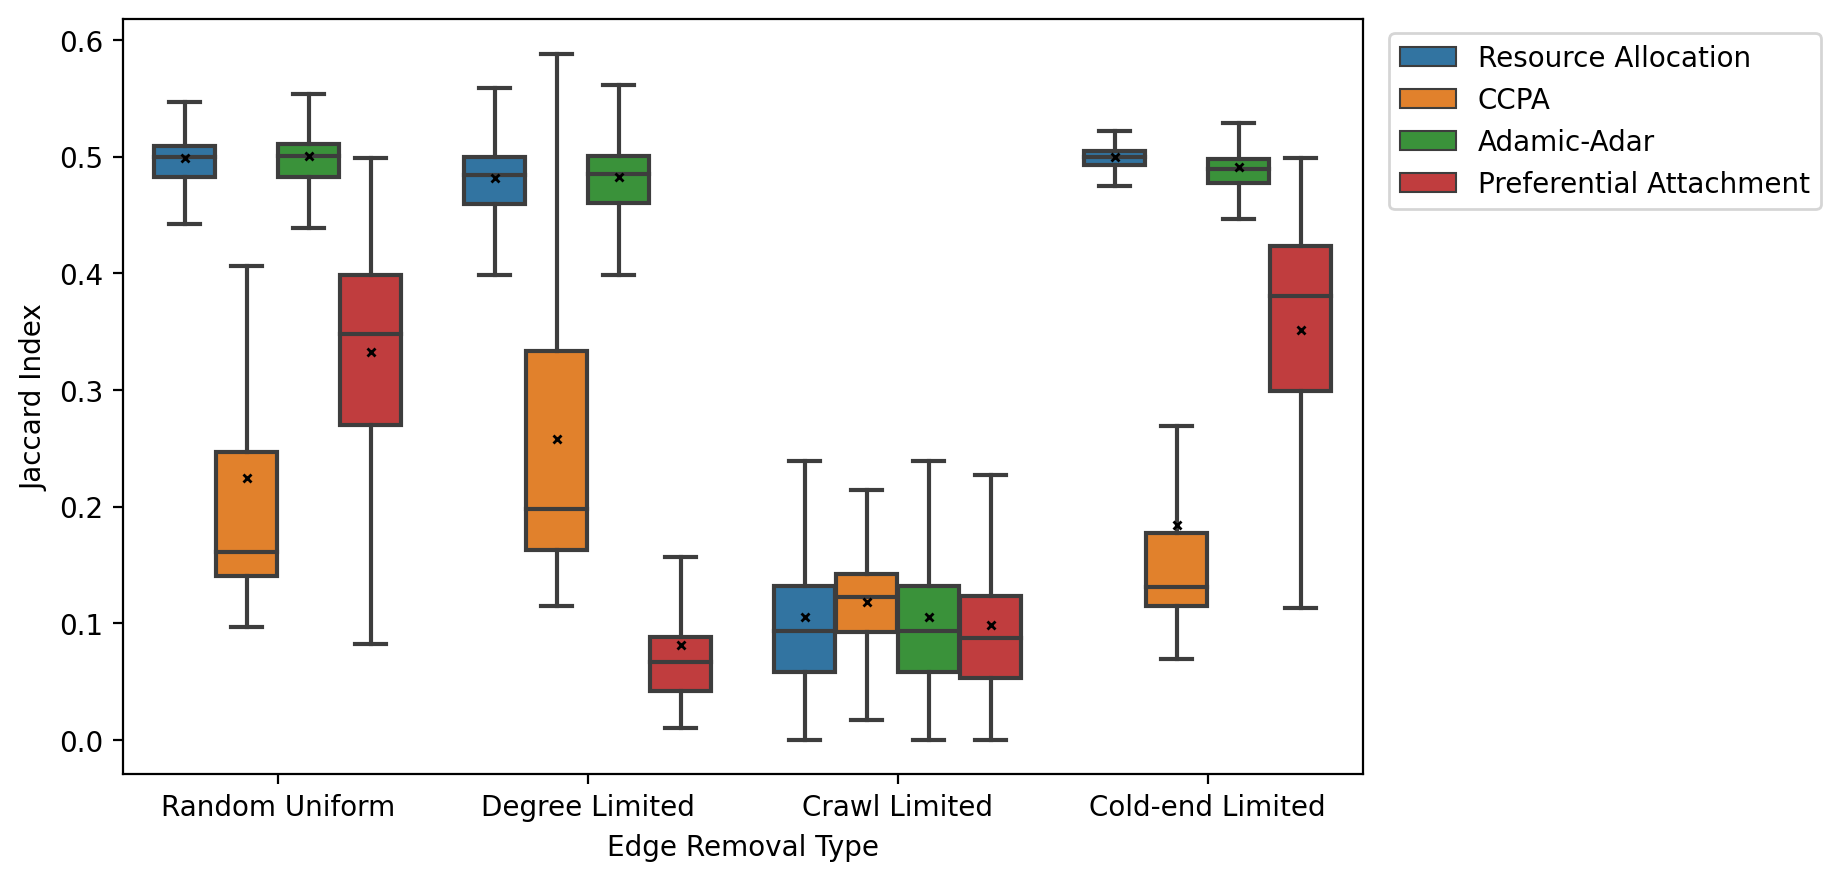

In [22]:

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 8, 5
fig = plt.figure()


    
tmp = df[df['evalMetric'] == 'jaccard']


sns.boxplot(data=tmp,
            x='missingType',
            hue='predictionAlgorithm',
            y='evalValue',
            showfliers=False,
            showmeans=True,
            meanprops={"marker":"x",
                       "markerfacecolor":"r", 
                       "markeredgecolor":"k",
                       "markersize":3})


plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.ylabel('Jaccard Index')
plt.xlabel('Edge Removal Type')


plt.show()

In [23]:
df.columns

Index(['cell', 'predictionAlgorithm', 'missingType', 'evalMetric', 'evalValue',
       'predMatrix', 'trainMatrix', 'trueMatrix'],
      dtype='object')

Text(0.5, 1.0, 'Imputed Matrix')

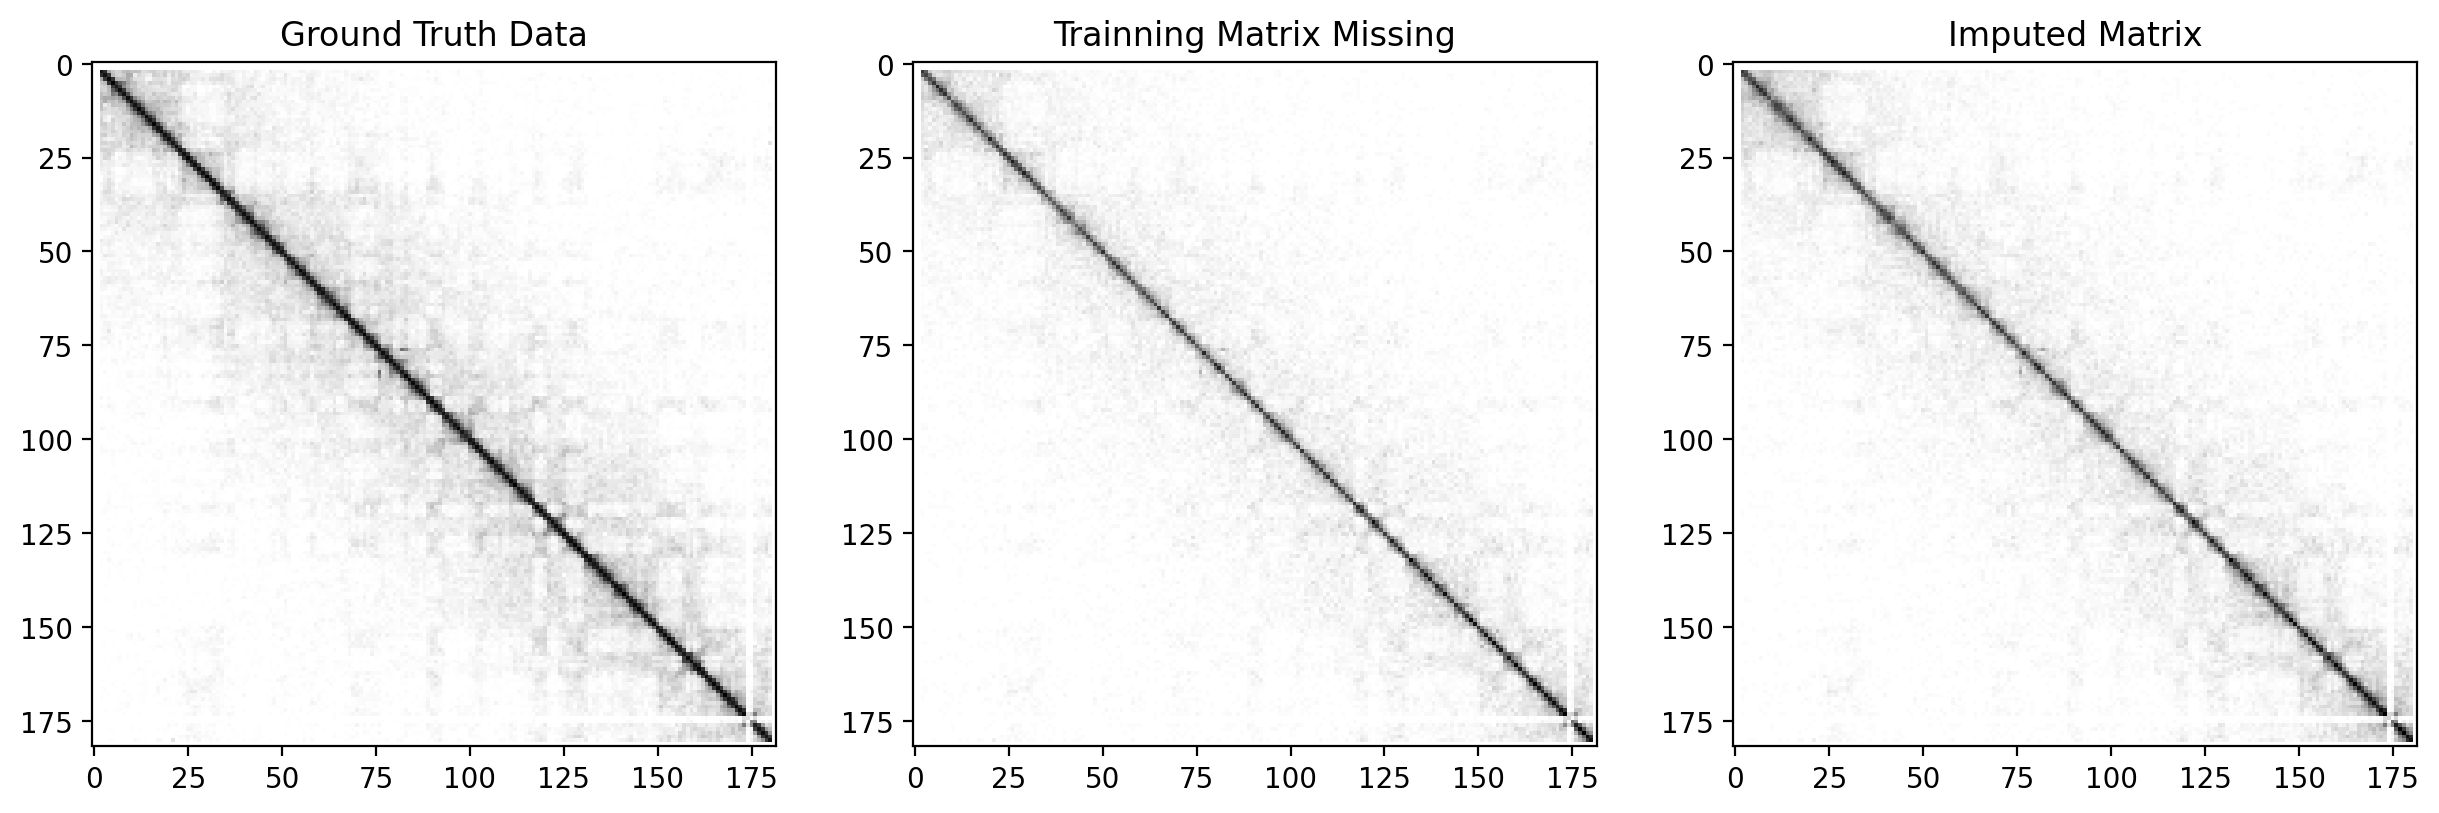

In [24]:
n = 100

sampleKeys = np.random.choice(df['cell'], n)
alg = 'Adamic-Adar' 
train = 'Degree Limited'


ensembleTrue = np.zeros((182, 182))
ensembleTrain = np.zeros((182, 182))
ensemblePred = np.zeros((182, 182))

for sampleKey in sampleKeys:
    
    mask = (df['cell'] == sampleKey) & (df['predictionAlgorithm'] == alg) & (df['missingType'] == train)
    row = df.loc[mask]
    
    ensembleTrue += row['trueMatrix'].values[0]
    ensembleTrain += row['trainMatrix'].values[0]
    ensemblePred += row['predMatrix'].values[0]
    


plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 15, 15
fig = plt.figure()

fig.add_subplot(131)
plt.imshow(ensembleTrue, cmap='binary')
plt.title(f'Ground Truth Data')

fig.add_subplot(132)
plt.imshow(ensembleTrain, cmap='binary')
plt.title('Trainning Matrix Missing')

fig.add_subplot(133)
plt.imshow(ensemblePred, cmap='binary')
plt.title('Imputed Matrix')
